# Precision and Recall in a multi-class multi-label setting

From Wikipedia (CC BY-SA 4.0):

<img 
     src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" 
     alt="Precision and Recall"
     width="25%"
/>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

from itertools import product
from IPython.display import display, Markdown

n_classes = 5
n_samples = 10
rg = np.random.default_rng(42)
np.set_printoptions(precision=2)
np.errstate(invalid='ignore', divide='ignore').__enter__()

## Dataset

Multi-class multi-label classification problem:
- Each sample can have multiple labels
- Predictions are made e.g. by applying a sigmoid activation

In [2]:
predictions = rg.random((n_samples, n_classes))

# Sample 8: all classes have prob >  .5
predictions[8] = predictions[8] * .3
# Sample 9: all classes have prob <= .5
predictions[9] = 1 - predictions[9] * .3

pd.DataFrame(predictions) \
    .rename_axis(index='Samples', columns='Classes') \
    .style \
    .format('{:.0%}') \
    .background_gradient(axis=None)

Classes,0,1,2,3,4
Samples,,,,,
0,77%,44%,86%,70%,9%
1,98%,76%,79%,13%,45%
2,37%,93%,64%,82%,44%
3,23%,55%,6%,83%,63%
4,76%,35%,97%,89%,78%
5,19%,47%,4%,15%,68%
6,74%,97%,33%,37%,47%
7,19%,13%,48%,23%,67%
8,13%,25%,21%,9%,25%


In [3]:
target = (rg.random(predictions.shape) > .5).astype(np.int)

# Sample 4: all classes are positive
target[4] = 1
# Sample 5: all classes are negative
target[5] = 0

pd.DataFrame(target) \
    .rename_axis(index='Samples', columns='Classes') \
    .style \
    .background_gradient(axis=None)

Classes,0,1,2,3,4
Samples,,,,,
0,0,0,1,1,1
1,1,0,1,0,0
2,1,0,1,1,1
3,1,1,0,0,0
4,1,1,1,1,1
5,0,0,0,0,0
6,1,0,1,0,0
7,0,1,0,0,1
8,0,1,0,0,0


## Accuracy score

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in `y_true`.

In [4]:
print('Accuracy:', sklearn.metrics.accuracy_score(
    y_true=target,
    y_pred=predictions > .5,
))

exact_matches = ((target == 1.) & (predictions > .5)).all(axis=1).sum()
print('Accuracy:', exact_matches / n_samples)

Accuracy: 0.0
Accuracy: 0.0


## Precision score

Precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. 

Precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

### Micro
Calculate metrics globally by counting the total true positives, false negatives and false positives.

Same as just considering all predictions as flattened.

In [5]:
print('TP/(TP + FP):', sklearn.metrics.precision_score(
    y_true=target,
    y_pred=predictions > .5,
    average='micro'
))

print('TP/(TP + FP):', sklearn.metrics.precision_score(
    y_true=target.ravel(),
    y_pred=predictions.ravel() > .5,
))

# Find tp and fp across all samples and all classes
tp = ((target == 1.) & (predictions > .5)).sum()
fp = ((target == 0.) & (predictions > .5)).sum()

print('TP:', tp)
print('FP:', fp)
print('TP/(TP+FP):', tp / (tp + fp))

TP/(TP + FP): 0.6
TP/(TP + FP): 0.6
TP: 15
FP: 10
TP/(TP+FP): 0.6


### Macro
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [6]:
print('TP/(TP + FP):', sklearn.metrics.precision_score(
    y_true=target,
    y_pred=predictions > .5,
    average='macro'
))

# Find class-wise tp and fp across all samples
tp = ((target == 1.) & (predictions > .5)).sum(axis=0, keepdims=True)
fp = ((target == 0.) & (predictions > .5)).sum(axis=0, keepdims=True)

display(
    pd.DataFrame({
        'tp': tp.squeeze(),
        'fp': fp.squeeze(),
        'tp / (tp + fp)': (tp / (tp + fp)).squeeze()
    })
    .rename_axis(index='Classes', columns='/')
    .transpose()
    .style
    .format('{:.0f}', subset=pd.IndexSlice[['tp', 'fp'], :])
    .format('{:.1%}', subset=pd.IndexSlice['tp / (tp + fp)', :])
)

print('TP/(TP+FP):', np.nan_to_num(tp / (tp + fp), nan=0.).mean(axis=1).item())

TP/(TP + FP): 0.6


Classes,0,1,2,3,4
/,,,,,
tp,4,1,4,3,3
fp,1,4,1,2,2
tp / (tp + fp),80.0%,20.0%,80.0%,60.0%,60.0%


TP/(TP+FP): 0.6


### Sample
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

In [7]:
print('TP/(TP + FP):', sklearn.metrics.precision_score(
    y_true=target,
    y_pred=predictions > .5,
    average='samples',
    zero_division=0
))

# Find sample-wise tp and fp across all classes
tp = ((target == 1.) & (predictions > .5)).sum(axis=1, keepdims=True)
fp = ((target == 0.) & (predictions > .5)).sum(axis=1, keepdims=True)

display(
    pd.DataFrame({
        'tp': tp.squeeze(),
        'fp': fp.squeeze(),
        'tp / (tp + fp)': (tp / (tp + fp)).squeeze()
    })
    .rename_axis(index='Samples')
    .style
    .format('{:.0f}', subset=pd.IndexSlice[:, ['tp', 'fp']])
    .format('{:.1%}', subset=pd.IndexSlice[:, 'tp / (tp + fp)'])
)

print('TP/(TP+FP):', np.nan_to_num(tp / (tp + fp), nan=0.).mean(axis=0).item())

TP/(TP + FP): 0.5233333333333333


,tp,fp,tp / (tp + fp)
Samples,,,
0,2,1,66.7%
1,2,1,66.7%
2,2,1,66.7%
3,1,2,33.3%
4,4,0,100.0%
5,0,1,0.0%
6,1,1,50.0%
7,1,0,100.0%
8,0,0,nan%


TP/(TP+FP): 0.5233333333333333


## Recall score

Recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. 

Recall is intuitively the ability of the classifier to find all the positive samples.

### Micro
Calculate metrics globally by counting the total true positives, false negatives and false positives.

Same as just considering all predictions as flattened.

In [8]:
print('TP/(TP + FN):', sklearn.metrics.recall_score(
    y_true=target,
    y_pred=predictions > .5,
    average='micro'
))

print('TP/(TP + FN):', sklearn.metrics.recall_score(
    y_true=target.ravel(),
    y_pred=predictions.ravel() > .5,
))

# Find tp and fn across all samples and all classes
tp = ((target == 1.) & (predictions > .5)).sum()
fn = ((target == 1.) & (predictions <= .5)).sum()

print('TP:', tp)
print('FN:', fn)
print('TP/(TP+FN):', tp / (tp + fn))

TP/(TP + FN): 0.6521739130434783
TP/(TP + FN): 0.6521739130434783
TP: 15
FN: 8
TP/(TP+FN): 0.6521739130434783


### Macro
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [9]:
print('TP/(TP + FN):', sklearn.metrics.recall_score(
    y_true=target,
    y_pred=predictions > .5,
    average='macro'
))

# Find class-wise tp and fn across all samples
tp = ((target == 1.) & (predictions > .5)).sum(axis=0, keepdims=True)
fn = ((target == 1.) & (predictions <= .5)).sum(axis=0, keepdims=True)

display(
    pd.DataFrame({
        'tp': tp.squeeze(),
        'fn': fn.squeeze(),
        'tp / (tp + fn)': (tp / (tp + fn)).squeeze()
    })
    .rename_axis(index='Classes', columns='/')
    .transpose()
    .style
    .format('{:.0f}', subset=pd.IndexSlice[['tp', 'fn'], :])
    .format('{:.1%}', subset=pd.IndexSlice['tp / (tp + fn)', :])
)

print('TP/(TP+FN):', np.nan_to_num(tp / (tp + fn), nan=0.).mean(axis=1).item())

TP/(TP + FN): 0.6633333333333333


Classes,0,1,2,3,4
/,,,,,
tp,4,1,4,3,3
fn,2,3,1,0,2
tp / (tp + fn),66.7%,25.0%,80.0%,100.0%,60.0%


TP/(TP+FN): 0.6633333333333333


### Sample
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

In [10]:
print('TP/(TP + FN):', sklearn.metrics.recall_score(
    y_true=target,
    y_pred=predictions > .5,
    average='samples',
    zero_division=0
))

# Find sample-wise tp and fn across all classes
tp = ((target == 1.) & (predictions > .5)).sum(axis=1, keepdims=True)
fn = ((target == 1.) & (predictions <= .5)).sum(axis=1, keepdims=True)

display(
    pd.DataFrame({
        'tp': tp.squeeze(),
        'fn': fn.squeeze(),
        'tp / (tp + fn)': (tp / (tp + fn)).squeeze()
    })
    .rename_axis(index='Samples')
    .style
    .format('{:.0f}', subset=pd.IndexSlice[:, ['tp', 'fn']])
    .format('{:.1%}', subset=pd.IndexSlice[:, 'tp / (tp + fn)'])
)

print('TP/(TP+FN):', np.nan_to_num(tp / (tp + fn), nan=0.).mean(axis=0).item())

TP/(TP + FN): 0.5466666666666666


,tp,fn,tp / (tp + fn)
Samples,,,
0,2,1,66.7%
1,2,0,100.0%
2,2,2,50.0%
3,1,1,50.0%
4,4,1,80.0%
5,0,0,nan%
6,1,1,50.0%
7,1,1,50.0%
8,0,1,0.0%


TP/(TP+FN): 0.5466666666666666


## Classification Report

In [11]:
print(sklearn.metrics.classification_report(
    y_true=target,
    y_pred=predictions > .5,
    target_names=[f'class {c}' for c in range(n_classes)],
    zero_division=0
))

              precision    recall  f1-score   support

     class 0       0.80      0.67      0.73         6
     class 1       0.20      0.25      0.22         4
     class 2       0.80      0.80      0.80         5
     class 3       0.60      1.00      0.75         3
     class 4       0.60      0.60      0.60         5

   micro avg       0.60      0.65      0.63        23
   macro avg       0.60      0.66      0.62        23
weighted avg       0.63      0.65      0.63        23
 samples avg       0.52      0.55      0.51        23



## Precision-Recall Curves

Mock dataset with more classes:

In [12]:
n_samples = 1000

classes = {
    c: (class_type, classifier_result, f'{class_type:>8} - {classifier_result:<4}')
    for c, (class_type, classifier_result) in 
    enumerate(product(
        ['common', 'balanced', 'rare'],
        ['ok', 'bias', 'zero', 'one']
    ))
}

target = np.zeros((n_samples, len(classes)), dtype=np.int)
predictions = np.zeros_like(target, dtype=np.float)

for c, (class_type, classifier_result, _) in classes.items():
    if class_type == 'common':
        target[rg.permutation(n_samples)[:int(.90 * n_samples)], c] = 1
    elif class_type == 'balanced':
        target[:, c] = rg.uniform(size=n_samples) > .5
    elif class_type == 'rare':
        target[rg.permutation(n_samples)[:int(.10 * n_samples)], c] = 1
        
    if classifier_result == 'ok':
        # Predict according to the true value with reasonable confidence
        predictions[:, c] = np.where(target[:, c], .7, .3) + rg.normal(loc=0., scale=.2, size=n_samples)
    elif classifier_result == 'bias':
        # Predict 1 at random following the class percentage
        predictions[:, c] = rg.uniform(size=n_samples) < (target[:, c].sum() / n_samples)
    elif classifier_result == 'zero':
        # Predict 0s
        predictions[:, c] = 0.
    elif classifier_result == 'one':
        # Predict 1s
        predictions[:, c] = 1.
        
predictions = predictions.clip(0, 1)
        
display(pd.DataFrame(
    np.stack([target, predictions], axis=0).mean(axis=1), 
    index=pd.Index(['Target', 'Predictions'], name='/'), 
    columns=pd.Index([name for (*_, name) in classes.values()], name='Class - Result')
).transpose().style.format('{:.1%}'))

print(sklearn.metrics.classification_report(
    y_true=target,
    y_pred=predictions > .5,
    target_names=[name for (*_, name) in classes.values()],
    zero_division=0
))

/,Target,Predictions
Class - Result,,
common - ok,90.0%,64.6%
common - bias,90.0%,90.0%
common - zero,90.0%,0.0%
common - one,90.0%,100.0%
balanced - ok,49.2%,50.6%
balanced - bias,51.5%,49.6%
balanced - zero,51.6%,0.0%
balanced - one,50.5%,100.0%
rare - ok,10.0%,33.6%


                 precision    recall  f1-score   support

  common - ok         0.99      0.83      0.90       900
  common - bias       0.90      0.90      0.90       900
  common - zero       0.00      0.00      0.00       900
  common - one        0.90      1.00      0.95       900
balanced - ok         0.81      0.84      0.82       492
balanced - bias       0.51      0.49      0.50       515
balanced - zero       0.00      0.00      0.00       516
balanced - one        0.51      1.00      0.67       505
    rare - ok         0.40      0.88      0.55       100
    rare - bias       0.11      0.09      0.10       100
    rare - zero       0.00      0.00      0.00       100
    rare - one        0.10      1.00      0.18       100

      micro avg       0.64      0.63      0.64      6028
      macro avg       0.43      0.59      0.46      6028
   weighted avg       0.58      0.63      0.59      6028
    samples avg       0.64      0.63      0.63      6028



Precision-Recall curves using _micro_ averaging, i.e. all predictions together.

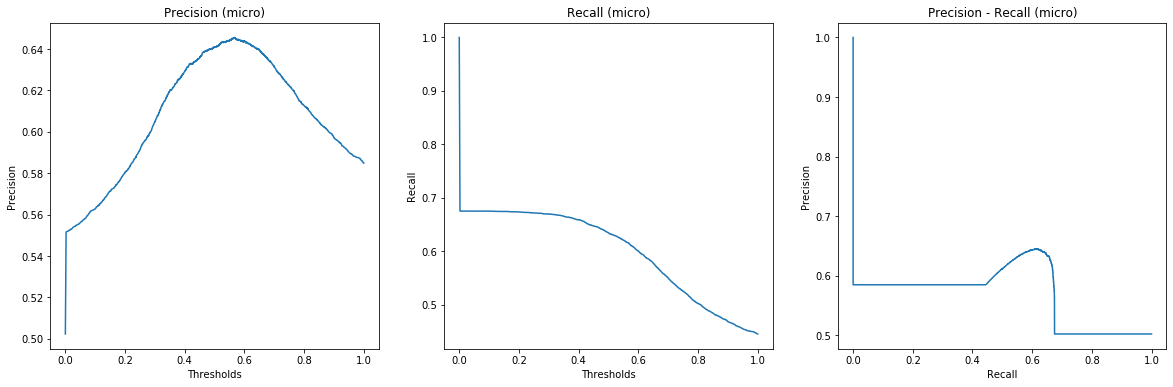

In [13]:
prec, rec, thres = sklearn.metrics.precision_recall_curve(
    y_true=target.ravel(),
    probas_pred=predictions.ravel(),
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax0, ax1, ax2 = axes.ravel()

ax0.plot(thres, prec[:-1])
ax0.set_xlabel('Thresholds')
ax0.set_ylabel('Precision')
ax0.set_title('Precision (micro)')

ax1.plot(thres, rec[:-1])
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Recall')
ax1.set_title('Recall (micro)')

ax2.step(rec, prec, where='post')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision - Recall (micro)');

Precision-Recall curves using _micro_ averaging for _ok_ results, i.e. all predictions together.

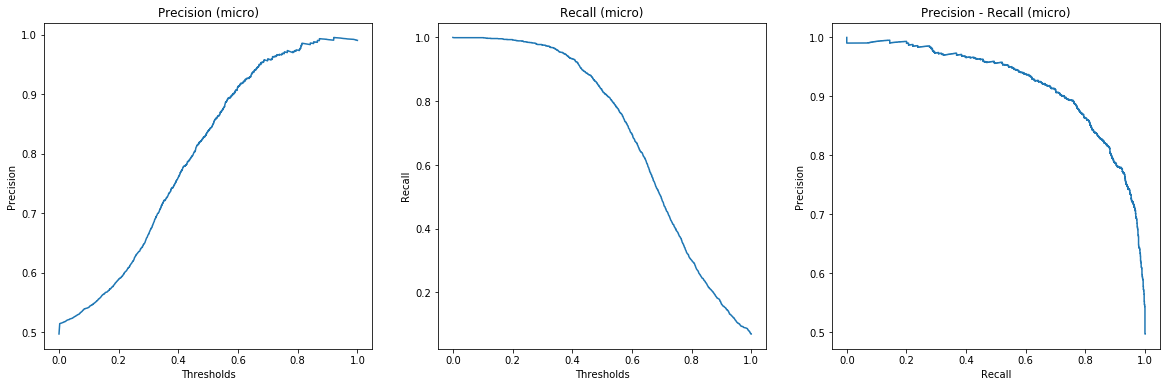

In [14]:
ok_results = [c for c, (_, classifier_result, _) in classes.items() if classifier_result == 'ok']

prec, rec, thres = sklearn.metrics.precision_recall_curve(
    y_true=target[:, ok_results].ravel(),
    probas_pred=predictions[:, ok_results].ravel(),
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax0, ax1, ax2 = axes.ravel()

ax0.plot(thres, prec[:-1])
ax0.set_xlabel('Thresholds')
ax0.set_ylabel('Precision')
ax0.set_title('Precision (micro)')

ax1.plot(thres, rec[:-1])
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Recall')
ax1.set_title('Recall (micro)')

ax2.step(rec, prec, where='post')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision - Recall (micro)');

Per class plots:
- Predictions that collapsed to all `1`s or all `0`s are not visible.
- Thresholding has no effect on the precision of biased predictions, but they will have a declining recall.
- Ok predictions have nice PR plots.

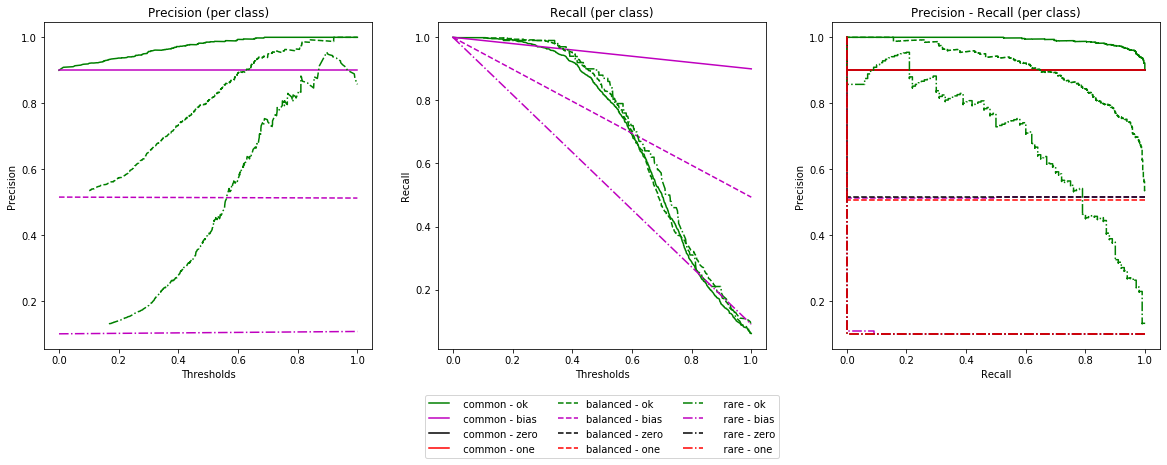

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax0, ax1, ax2 = axes.ravel()

linestyles = {'common': '-', 'balanced': '--', 'rare': '-.'}
colors = {'ok': 'g', 'zero': 'k', 'one': 'r', 'bias': 'm'}

for c, (class_type, classifier_result, name) in classes.items():
    prec, rec, thres = sklearn.metrics.precision_recall_curve(
        y_true=target[:, c],
        probas_pred=predictions[:, c],
    )
    linestyle = linestyles[class_type]
    c = colors[classifier_result]
    ax0.plot(thres, prec[:-1], c=c, linestyle=linestyle)
    ax1.plot(thres, rec[:-1], c=c, linestyle=linestyle, label=name)
    ax2.step(rec, prec, where='post', c=c, linestyle=linestyle)

ax0.set_xlabel('Thresholds')
ax0.set_ylabel('Precision')
ax0.set_title('Precision (per class)')

ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Recall')
ax1.set_title('Recall (per class)')
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0, -.35, 1, 1))

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision - Recall (per class)');